In [1]:
import pandas as pd
from sklearn.mixture import GaussianMixture

In [2]:
big_df = pd.read_csv('big_df_clean.csv')

In [3]:
big_df['AGE'] = big_df['AGE'].fillna(big_df['AGE'].mean())

for i in big_df.columns[11:]:
    if i.split('_')[-1] in ['MEAN', 'COUNT']:
        big_df[i].fillna(0, inplace=True)
    else:
        big_df[i].fillna('NO_DATA', inplace=True)

In [4]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46142 entries, 0 to 46141
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CUST_NUM                46142 non-null  float64
 1   PROVINCE                46142 non-null  object 
 2   REGION                  46142 non-null  object 
 3   EDUCATION               46142 non-null  object 
 4   AGE                     46142 non-null  float64
 5   TENURE                  46142 non-null  float64
 6   BUSINESS_OWNER          46142 non-null  object 
 7   DIGITAL_FLAG            46142 non-null  object 
 8   INCOME_SOURCE           46142 non-null  object 
 9   GENDER                  46142 non-null  object 
 10  MARITAL_STATUS          46142 non-null  object 
 11  CREDIT_MEAN             46142 non-null  float64
 12  CREDIT_COUNT            46142 non-null  float64
 13  CREDIT_CHANNEL          46142 non-null  object 
 14  CREDIT_MERCH_GROUP      46142 non-null

In [5]:
big_df.to_csv('big_df_final.csv')

### Standardizing and One-hot Encoding

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [7]:
dfp = big_df.copy().drop('CUST_NUM', axis=1)

df_num = dfp.select_dtypes(exclude='object')
df_cat = dfp.select_dtypes(include='object')

for c in df_num.columns:
    pt = PowerTransformer() # for skewed
    df_num.loc[:, c] = pt.fit_transform(np.array(df_num[c]).reshape(-1, 1))

# one-hot encoding
df_cat = pd.get_dummies(df_cat)
# combine scaled numerical and categorical dummy variables in a dataframe
dfp_combined = pd.concat([df_num, df_cat], axis=1)
# standardize the data to have a mean of ~0 and a variance of 1
dfp_scaled = StandardScaler().fit_transform(dfp_combined)

In [8]:
n_components = range(1, 11)  # Try different numbers of components
models = [GaussianMixture(n, random_state=0).fit(dfp_scaled) for n in n_components]
bic = [model.bic(dfp_scaled) for model in models]
aic = [model.aic(dfp_scaled) for model in models]

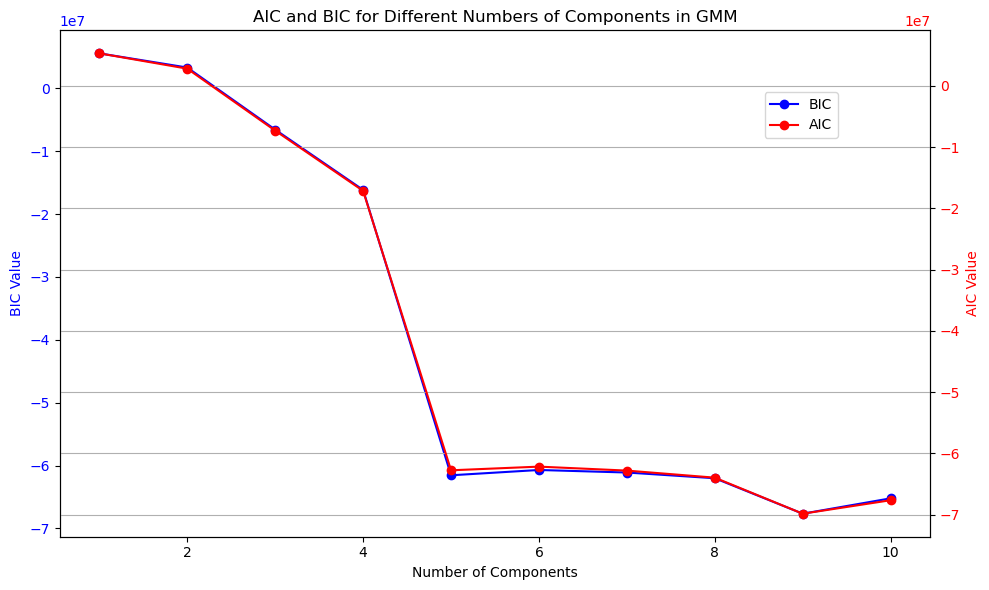

In [9]:
import matplotlib.pyplot as plt

n_components = range(1, 11)  
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot BIC on the first y-axis
ax1.plot(n_components, bic, marker='o', linestyle='-', color='b', label='BIC')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('BIC Value', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for AIC
ax2 = ax1.twinx()
ax2.plot(n_components, aic, marker='o', linestyle='-', color='r', label='AIC')
ax2.set_ylabel('AIC Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set titles and legends
plt.title('AIC and BIC for Different Numbers of Components in GMM')
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))

# Show the plot
plt.grid(True)
plt.show()

In [10]:
n_components_optimal = 5
gmm = GaussianMixture(n_components=n_components_optimal, random_state=0)
gmm.fit(dfp_scaled)

GaussianMixture(n_components=5, random_state=0)

In [11]:
cluster_labels = gmm.predict(dfp_scaled)

In [12]:
dfp1 = big_df.copy()

dfp1.insert(0, 'CLUSTER', cluster_labels)
dfp1.head()

,CLUSTER,CUST_NUM,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,...,DIGITAL_CHANNEL,DIGITAL_TRAN_TYPE,INCOMING_MEAN,INCOMING_COUNT,INCOMING_BPI_ACCT_TYPE,INCOMING_SRC_BANK_NAME,OUTGOING_MEAN,OUTGOING_COUNT,OUTGOING_CHANNEL,OUTGOING_RCV_BANK_NAME
0,4,11712.654012,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,20.0,1.833333,N,DIGITAL,ALLOWANCE,...,MOBILE,BILLS PAYMENT,2619.191451,5.0,SA,HUMAN,1626.116225,17.0,MOBILE,HUMAN
1,2,436.605085,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,21.0,4.250000,N,NO_DATA,SALARY,...,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA
2,2,921.989154,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,23.0,2.000000,N,TRADITIONAL,ALLOWANCE,...,WEB,E-WALLET,3349.209339,4.0,SA,HUMAN,0.000000,0.0,NO_DATA,NO_DATA
3,2,1119.634762,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),LOW,13.0,5.583333,N,TRADITIONAL,ALLOWANCE,...,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA
4,2,1709.755538,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,20.0,1.250000,N,DIGITAL,SALARY,...,WEB,E-WALLET,3886.745466,4.0,SA,CAT,0.000000,0.0,NO_DATA,NO_DATA


In [13]:
dfp1.to_csv('dfp_gmm.csv')

In [14]:
dfp1["CLUSTER"].value_counts()

2    33835
0     5009
4     3082
3     2143
1     2073
Name: CLUSTER, dtype: int64

## Visualize

In [15]:
df_dfp_scaled = pd.DataFrame(dfp_scaled)

In [16]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(df_dfp_scaled)

C:\Users\Rafael D. Tagulao\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Rafael D. Tagulao\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


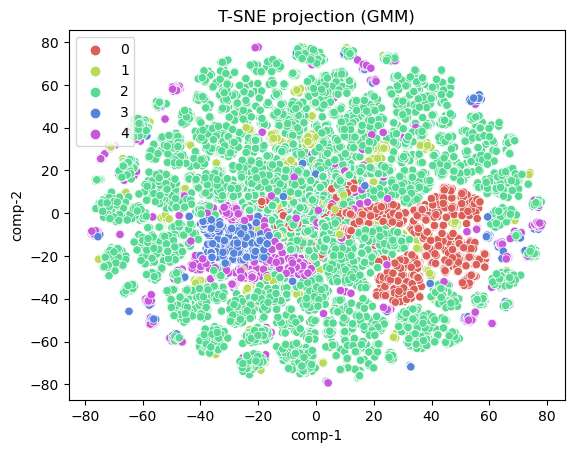

In [21]:
import seaborn as sns

dfp_kmeans = pd.DataFrame()
dfp_kmeans['CLUSTER'] = dfp1['CLUSTER']
dfp_kmeans['comp-1'] = transformed[:,0]
dfp_kmeans['comp-2'] = transformed[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=dfp_kmeans.CLUSTER.tolist(),
                palette=sns.color_palette('hls',5),
                data=dfp_kmeans).set(title="T-SNE projection (GMM)")

plt.savefig('T-SNE_GMM.png')
plt.show()

Average Silhouette Score: 0.004604885358678411


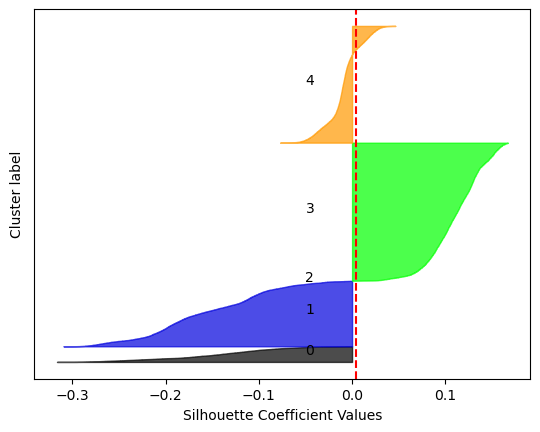

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

X = df_dfp_scaled
k = 5

model = KMeans(n_clusters=k)
cluster_labels = model.fit_predict(X)

# Calculate the silhouette score for the entire dataset
silhouette_avg = silhouette_score(X, cluster_labels)
print("Average Silhouette Score:", silhouette_avg)

# Calculate silhouette scores for each data point
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Create a silhouette plot
fig, ax = plt.subplots()
y_lower = 10

for i in range(k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for the next plot
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster label")

# The vertical line indicates the average silhouette score
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])  # Clear the y-axis labels
plt.show()